In [14]:

import yaml
import os

from numpy import *
import luxeics
import h5py

from scipy.interpolate import interp2d,RectBivariateSpline

import matplotlib.pyplot as plt

import luxeics

def sortSecond(val):
    return val[1] 
def Photon_density(spotsize,input_filename,path,Filter):
    with h5py.File(f'{path}{os.sep}H_Five{os.sep}'+input_filename+'.h5'  ,'r') as ff:
 

        K0,K1,K2,K3  = ff['final-state/photon/momentum'][:].T
        X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
        W            = ff['final-state/photon/weight'  ][:]

    with open( f'{path}{os.sep}Yml_Files{os.sep}'+input_filename+'.yml' , 'r' ) as stream:
        input_dict = yaml.load(stream, Loader=yaml.SafeLoader)
        sigmaT   = float(input_dict['beam']['sigmaX'])
        baseline     = float( input_dict['beam']['baseline'])
        w0               = float(input_dict['laser']['w0'])
        a0               = float(input_dict['laser']['a0'])
    
    
    baseline = 7.5e6

    thetax=K1/K3
    thetay=K2/K3

     

    xoffset = thetax * baseline
    yoffset = thetay * baseline
    
    
    Area = pi  * spotsize ** 2
    selector = sqrt( ( xoffset + X1 ) ** 2 + ( yoffset + X2 ) ** 2) < spotsize
    K_inside_Spot=K0[selector]
    W_inside_Spot=W[selector]
    
    
    '''
    Selecting Photons with energy more than 8 GeV
    
    '''
    
    
    if (Filter=='Y' or Filter =='y'):
        selector2=K_inside_Spot*10**(-9)> 8.0
        K_inside_Spot=K_inside_Spot[selector2]
        W_inside_Spot=W_inside_Spot[selector2]
    
    
    Photon_Density = sum ( W_inside_Spot  ) /  Area
    plt.figure(figsize=(14,6))

    

    ax1=plt.subplot(122,aspect=1)
    plt.scatter(X1+xoffset, X2+yoffset, color='m', marker='.',lw=0,s=W);

    plt.xlim(-2*spotsize,2*spotsize)
    plt.ylim(-2*spotsize,2*spotsize)

    plt.xlabel(r'$x$ (micron)')
    plt.ylabel(r'$y$ (micron)');
    plt.title(f'Finite source size, Photon density:{round(Photon_Density,2)} micron^(-2)')


    ax1.add_patch(plt.Circle((0,0),spotsize,color='C0',fill=False))


    plt.suptitle(f' sigmaT :{sigmaT} microns W0 : {w0} microns a0:{round(a0,2)} microns, spotsize:{spotsize} micron')
    #plt.savefig(f'{path}\photon_spectrum_at_focus_{sigmaT}_{spotsize}.png',dpi=200)

    


    return ( Photon_Density )
                                      
    
                                   
def run(spotsize,input_filename,path,Filter):
    
    "The following is just to check if the energy of the pulse is constant"
    
    
    with open( f'{path}{os.sep}Yml_Files{os.sep}'+input_filename+'.yml' , 'r' ) as stream:
        input_dict = yaml.load(stream, Loader=yaml.SafeLoader)


        a0               = float(input_dict['laser']['a0'])        
        
        TPulse               = float(input_dict['laser']['Tpulse'])
        w0               = float(input_dict['laser']['w0'])
        omega0           = float(input_dict['laser']['omega0'])
        sigmaT   = float(input_dict['beam']['sigmaX'])
        L = float(input_dict['beam']['L'])

    me=0.511*10**6
    alpha=1/137
    Energy=(TPulse*(me*omega0*a0*w0)**2)/(8*alpha)
    Energy=Energy*0.3/((0.197326)**3)
    
    
    
    
    Pd=Photon_density(spotsize,input_filename,path,Filter)
    
    
    
    
    
    return(Pd,L,Energy)

Files and Directories in 'C:\Users\Dupish\Documents\GitHub\luxeics\Photon_Density\L_Para_Run':


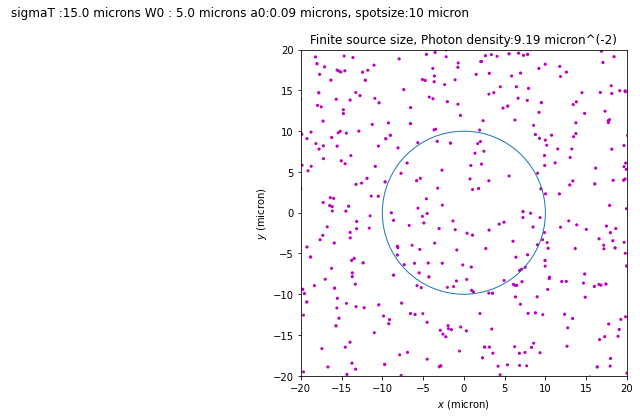

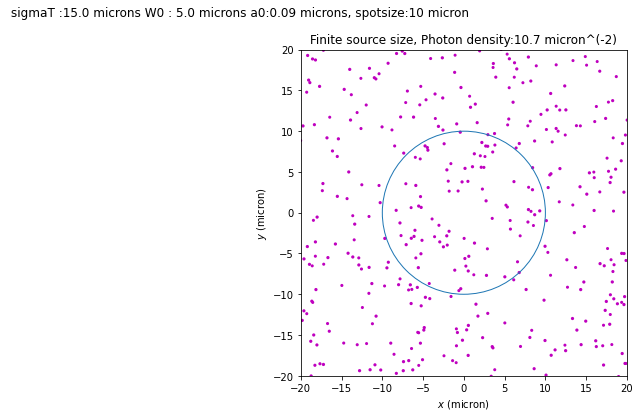

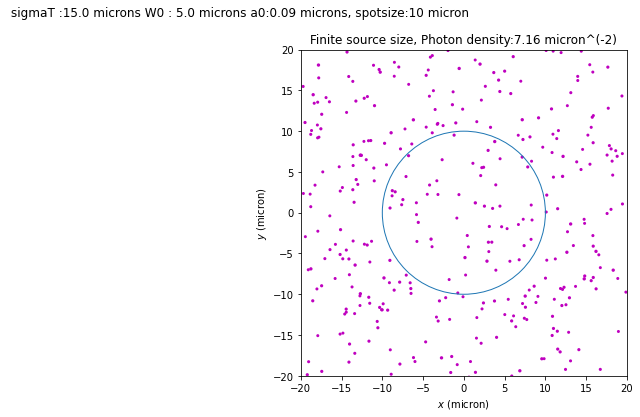

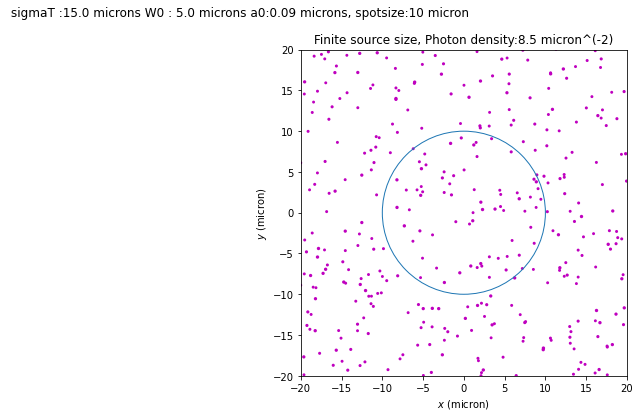

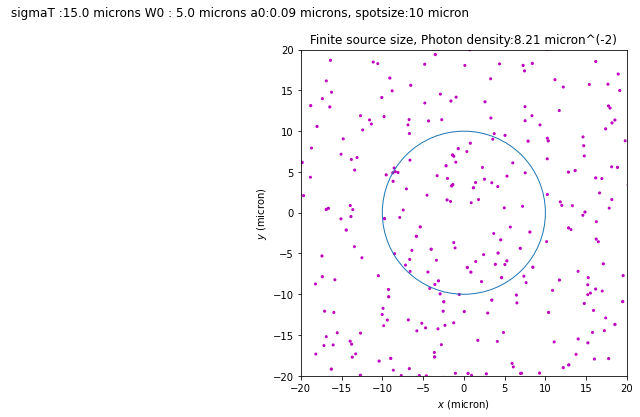

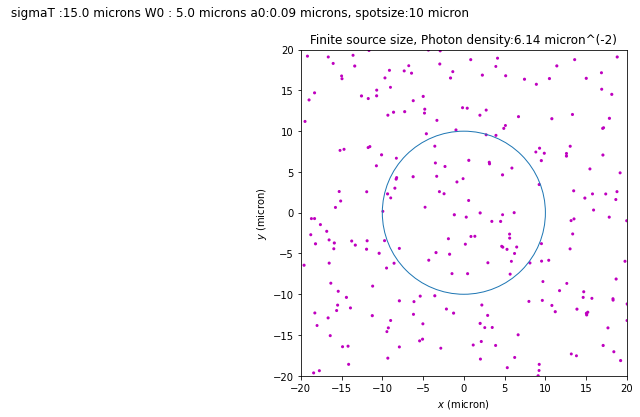

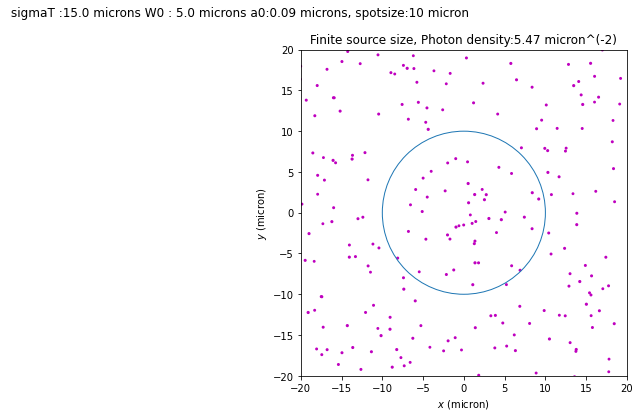

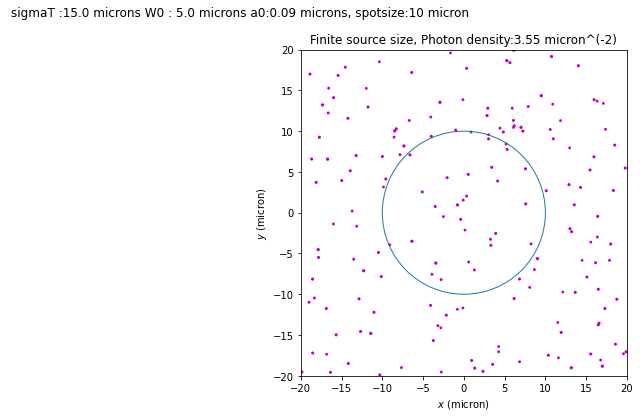

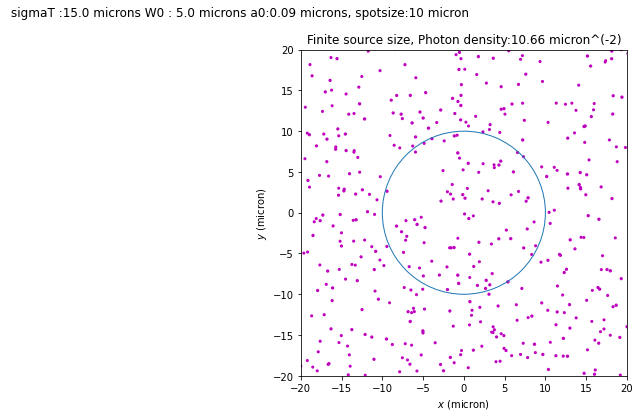

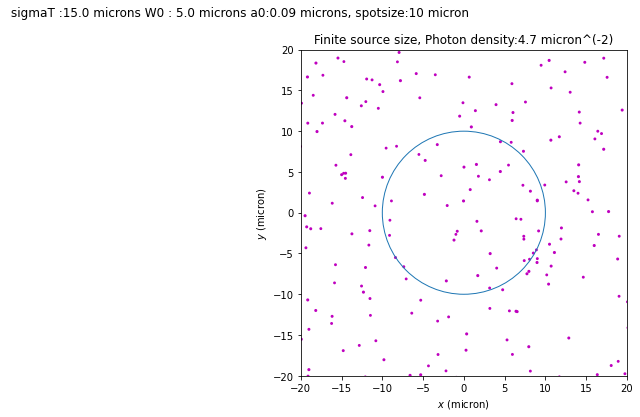

In [15]:

input_filename=f'{os.getcwd()}{os.sep}YML_Files{os.sep}L_Para_Run'

spotsize = 10

with open( input_filename + '.yml', 'r' ) as stream:
               
            
            
            input_dict = yaml.load(stream, Loader=yaml.SafeLoader)
            

            directory	=input_dict['control']['folder']


path = f"{os.getcwd()}{os.sep}Photon_Density{os.sep}{directory}"


object = os.scandir(path+f'{os.sep}H_Five')

print("Files and Directories in '% s':" % path)



PD_Constant_w0 = []



for n in object :
    


        PD_Constant_w0.append( run(spotsize,f'{os.path.splitext(n.name)[0]}', f'{path}','n'))
        

object.close()


PD_Constant_w0.sort(key = sortSecond)
PD_Constant_w0=array(PD_Constant_w0)

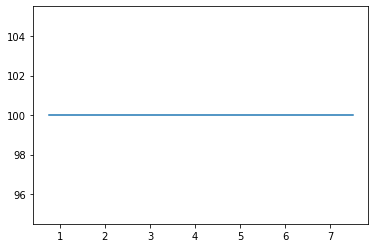

No handles with labels found to put in legend.


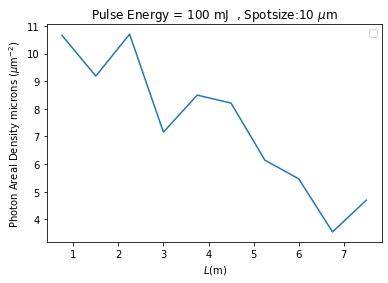

In [16]:
plt.plot(array(PD_Constant_w0)[:,1]*10**(-6),array(PD_Constant_w0)[:,2]/(6.242*10**15))
plt.show()
plt.plot(array(PD_Constant_w0)[:,1]*10**(-6),array(PD_Constant_w0)[:,0])
plt.xlabel(r' $L$(m) ')
plt.ylabel(r'Photon Areal Density microns ($\mu$m$^{-2}$)')

plt.title(f'Pulse Energy = 100 mJ  , Spotsize:{spotsize} $\mu$m')
plt.legend()
plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Spotsize{spotsize}_Finite.png',dpi=200)



In [17]:
print(array(PD_Constant_w0)[:,2]*10**(-9))

[6.242e+08 6.242e+08 6.242e+08 6.242e+08 6.242e+08 6.242e+08 6.242e+08
 6.242e+08 6.242e+08 6.242e+08]


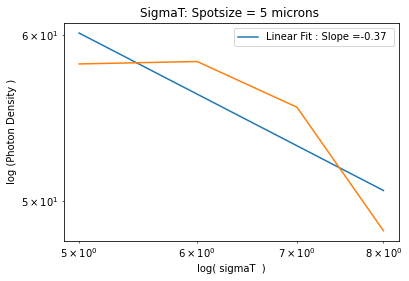

In [78]:
z=(polyfit(log(PD_Constant_w0[:,1].astype('float64')),log(PD_Constant_w0[:,0].astype('float64')),1))
poly = poly1d(z)
x=log(PD_Constant_w0[:,1])
y=poly(x)
plt.plot(exp(x),exp(y),label=f'Linear Fit : Slope ={round(z[0],2)} ')
plt.plot((PD_Constant_w0[:,1]),(PD_Constant_w0[:,0]))
plt.title(f'SigmaT: Spotsize = {spotsize} microns ')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log( sigmaT  )')
plt.ylabel(f'log (Photon Density )')
plt.legend()
plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Spotsize{spotsize}_Finite_Log_Scale.png',dpi=200)


In [79]:
'''
Saving the Data
'''
Pd=PD_Constant_w0

import pandas as pd
import numpy as np
import os
n=np.shape(Pd)
print(n)
Data=np.zeros((n))
Data[:,0]=Pd[:,0]
Data[:,1]=Pd[:,1]
Data[:,2]=Pd[:,2]*1.60218*10**(-16)

df=pd.DataFrame(Data)

List=["Photon Density ","W_0","Energy(mJ)"]
df.to_csv(f'{path}\Photon_Density_Spotsize{spotsize}.txt',header=List , index=None, sep="\t", mode='w')



print(df)

(4, 3)
           0    1           2
0  58.104466  5.0  100.008076
1  58.260069  6.0  100.008076
2  55.417518  7.0  100.008076
3  48.414786  8.0  100.008076


In [80]:
'''
Reading the text files
The final array p does not contain the Header files

'''
print(pd.read_csv(f'{path}\Photon_Density_Spotsize{spotsize}.txt',header=None , sep="\t"))

r=pd.read_csv(f'{path}\Photon_Density_Spotsize{spotsize}.txt',header=0 , sep="\t")
Pd_SigmaT=pd.DataFrame.to_numpy(r)

                   0    1                   2
0    Photon Density   W_0          Energy(mJ)
1  58.10446587276541  5.0         100.0080756
2  58.26006910580344  6.0  100.00807559999997
3  55.41751845954609  7.0  100.00807559999997
4   48.4147855596434  8.0  100.00807559999997


In [81]:

plt.plot(np.array(Pd_SigmaT)[:,1],np.array(Pd_SigmaT)[:,0],label='W0 = 5 microns [constant]')

plt.plot(np.array(PD_Constant_w0)[:,1],np.array(PD_Constant_w0)[:,0],label='W0=SigmaT')
plt.xlabel(r'Electron Beam Size $\sigmaT=w0$[micron] ')
plt.ylabel('(Photon Areal Density )$[microns]^-2$')

plt.title(f' Spotsize:{spotsize} microns')
plt.legend()
plt.savefig(f'{path}\Combined_Parameter_runs_Spotsize{spotsize}_Finite.png',dpi=200)



ValueError: 
\sigmaT=w0
^
Unknown symbol: \sigmaT, found '\'  (at char 0), (line:1, col:1)

ValueError: 
\sigmaT=w0
^
Unknown symbol: \sigmaT, found '\'  (at char 0), (line:1, col:1)

<Figure size 432x288 with 1 Axes>

In [ ]:
E =(100 * 10**(-3))  *(6.242*10**18)  # eV
T = 1000 #fs
alpha=1/137
m=511000   #eV
omega=4.1  #eV
a=8*alpha/(m*omega)**2



constant=E*a/T


In [ ]:

constant=((0.197326**3)/0.3)*constant


In [18]:
print((constant**0.5)*10)

4.611664199749397


In [1]:
print(225/7)

32.142857142857146


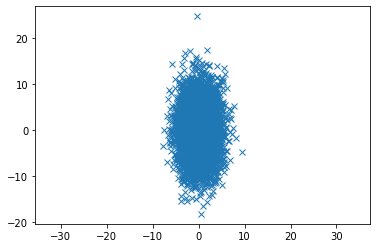

In [12]:
mean = [0, 0]
import numpy as np
cov = [[5, 0], [0, 25]]
import matplotlib.pyplot as plt

x,y = np.random.multivariate_normal(mean, cov, 5000).T

plt.plot(x, y, 'x')

plt.axis('equal')

plt.show()

In [6]:
print(np.shape(x))

(5000, 2)
